In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models & utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Oversampling for imbalanced datasets
try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("imblearn package not installed. Please install it with: pip install imbalanced-learn")

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)

import joblib  # For saving models
import time  # For tracking runtime
import os  # For file path handling

try:
    # Load dataset - ensure the file path is correct
    file_path = 'coronavirusdataset.csv'
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} was not found. Please check the file path.")
    
    df = pd.read_csv(file_path)
    
    # Display basic information
    print("Shape:", df.shape)
    print("\nColumns:\n", df.columns.tolist())
    print("\nNull Values:\n", df.isnull().sum())
    
    # Display first few rows
    print("\nFirst 5 rows:")
    print(df.head())
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    # Optionally, provide suggestions for common errors
    if "No such file or directory" in str(e):
        print("\nTIP: Make sure the CSV file is in your current working directory.")
        print("Current working directory:", os.getcwd())
    elif "Missing optional dependency" in str(e):
        print("\nTIP: You might be missing a required package. Try installing it with pip.")

imblearn package not installed. Please install it with: pip install imbalanced-learn
Shape: (7294, 45)

Columns:
 ['batch_date', 'test_name', 'swab_type', 'covid19_test_results', 'age', 'high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes', 'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker', 'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', 'rapid_flu_results', 'rapid_strep_results', 'ctab', 'labored_respiration', 'rhonchi', 'wheezes', 'days_since_symptom_onset', 'cough', 'cough_severity', 'fever', 'sob', 'sob_severity', 'diarrhea', 'fatigue', 'headache', 'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat', 'cxr_findings', 'cxr_impression', 'cxr_label', 'cxr_link']

Null Values:
 batch_date                          0
test_name                           0
swab_type                           0
covid19_test_results                0
age                                 0
high_risk_exposure_occupation       0
high_risk_interactions

In [11]:
print (df.info())
print (df.describe())
print (df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7294 entries, 0 to 7293
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   batch_date                     7294 non-null   object 
 1   test_name                      7294 non-null   object 
 2   swab_type                      7294 non-null   object 
 3   covid19_test_results           7294 non-null   object 
 4   age                            7294 non-null   int64  
 5   high_risk_exposure_occupation  7294 non-null   bool   
 6   high_risk_interactions         2727 non-null   object 
 7   diabetes                       7294 non-null   bool   
 8   chd                            7294 non-null   bool   
 9   htn                            7294 non-null   bool   
 10  cancer                         7294 non-null   bool   
 11  asthma                         7294 non-null   bool   
 12  copd                           7294 non-null   b

In [12]:
# check for null values
print("Check for Null Values: ", df.isnull().sum())

Check for Null Values:  batch_date                          0
test_name                           0
swab_type                           0
covid19_test_results                0
age                                 0
high_risk_exposure_occupation       0
high_risk_interactions           4567
diabetes                            0
chd                                 0
htn                                 0
cancer                              0
asthma                              0
copd                                0
autoimmune_dis                      0
smoker                              0
temperature                      5425
pulse                            5428
sys                              5567
dia                              5567
rr                               5750
sats                             5425
rapid_flu_results                7288
rapid_strep_results              7283
ctab                             6006
labored_respiration              5331
rhonchi                   

In [13]:
print("\nTarget variable (covid19_test_results) distribution:")
print(df['covid19_test_results'].value_counts())



Target variable (covid19_test_results) distribution:
Negative    7269
Positive      25
Name: covid19_test_results, dtype: int64


In [14]:
df.columns

Index(['batch_date', 'test_name', 'swab_type', 'covid19_test_results', 'age',
       'high_risk_exposure_occupation', 'high_risk_interactions', 'diabetes',
       'chd', 'htn', 'cancer', 'asthma', 'copd', 'autoimmune_dis', 'smoker',
       'temperature', 'pulse', 'sys', 'dia', 'rr', 'sats', 'rapid_flu_results',
       'rapid_strep_results', 'ctab', 'labored_respiration', 'rhonchi',
       'wheezes', 'days_since_symptom_onset', 'cough', 'cough_severity',
       'fever', 'sob', 'sob_severity', 'diarrhea', 'fatigue', 'headache',
       'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore',
       'sore_throat', 'cxr_findings', 'cxr_impression', 'cxr_label',
       'cxr_link'],
      dtype='object')

In [15]:
# Get categorical columns (dtype = object)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']

# Get numerical columns (dtype != object)
numerical_cols = [col for col in df.columns if df[col].dtype != 'object']

# Display the categorical columns
print("Categorical columns:\n", categorical_cols)


Categorical columns:
 ['batch_date', 'test_name', 'swab_type', 'covid19_test_results', 'high_risk_interactions', 'rapid_flu_results', 'rapid_strep_results', 'ctab', 'labored_respiration', 'rhonchi', 'wheezes', 'cough_severity', 'fever', 'sob_severity', 'cxr_findings', 'cxr_impression', 'cxr_label', 'cxr_link']


In [16]:
numerical_cols

['age',
 'high_risk_exposure_occupation',
 'diabetes',
 'chd',
 'htn',
 'cancer',
 'asthma',
 'copd',
 'autoimmune_dis',
 'smoker',
 'temperature',
 'pulse',
 'sys',
 'dia',
 'rr',
 'sats',
 'days_since_symptom_onset',
 'cough',
 'sob',
 'diarrhea',
 'fatigue',
 'headache',
 'loss_of_smell',
 'loss_of_taste',
 'runny_nose',
 'muscle_sore',
 'sore_throat']

In [17]:
# Full list of symptom columns
symptoms = [
    'cough', 'fever', 'sob', 'diarrhea', 'fatigue',
    'headache', 'loss_of_smell', 'loss_of_taste',
    'runny_nose', 'muscle_sore', 'sore_throat'
]

# Make a copy of the dataframe
df = df.copy()

# Convert boolean or string-boolean columns to numeric (0/1)
for col in symptoms:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'True': 1, 'False': 0, 'true': 1, 'false': 0})
    elif df[col].dtype == 'bool':
        df[col] = df[col].astype(int)


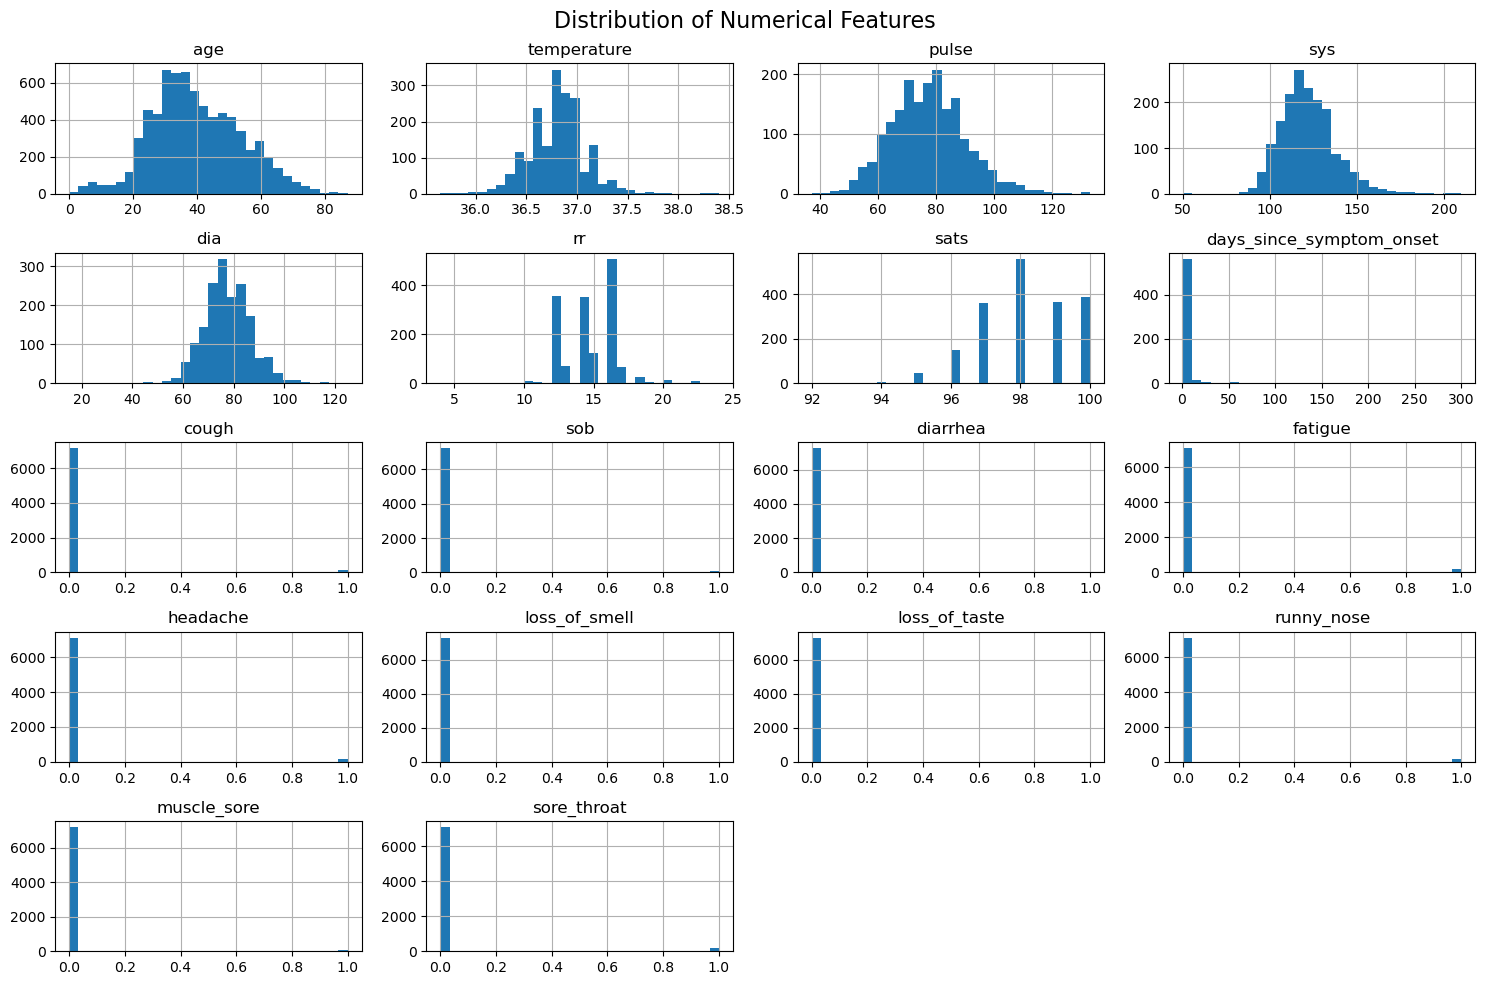

In [18]:
# Plot histograms for all numerical columns
df[numerical_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


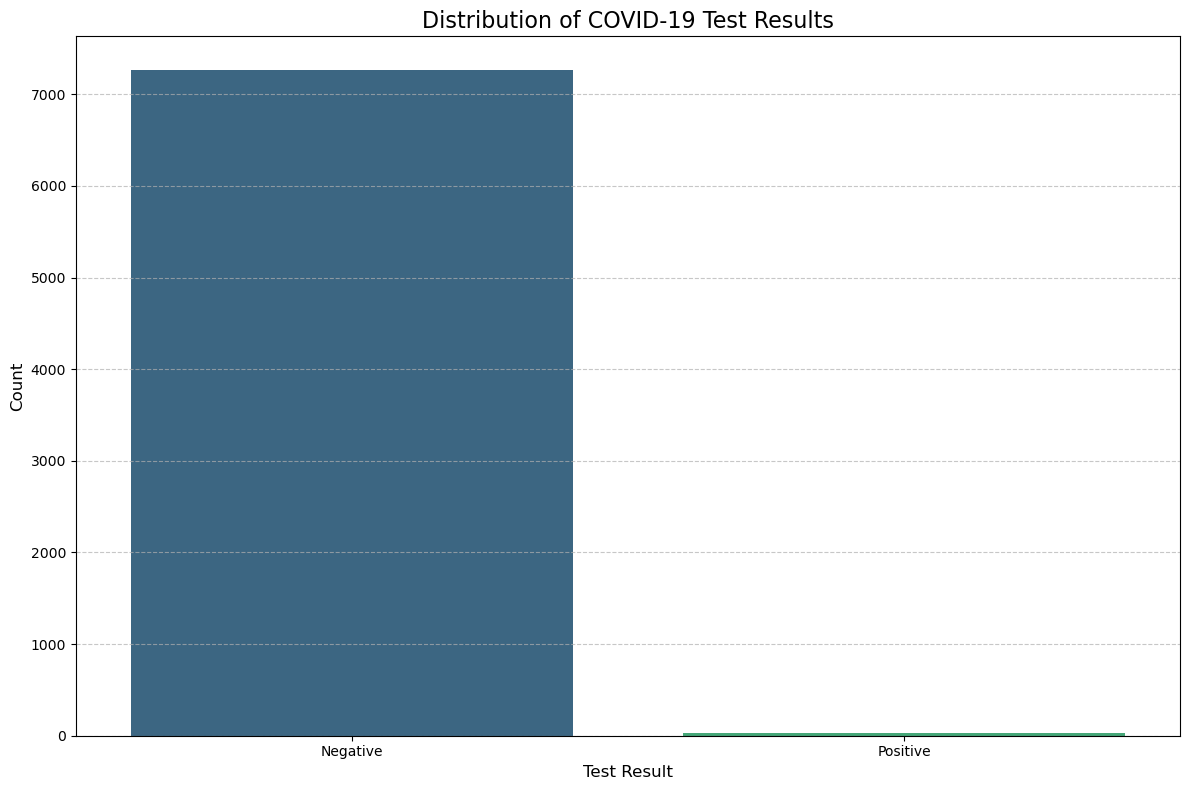

In [19]:
plt.figure(figsize=(12, 8))
sns.countplot(x='covid19_test_results', data=df, palette='viridis')
plt.title('Distribution of COVID-19 Test Results', fontsize=16)
plt.xlabel('Test Result', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


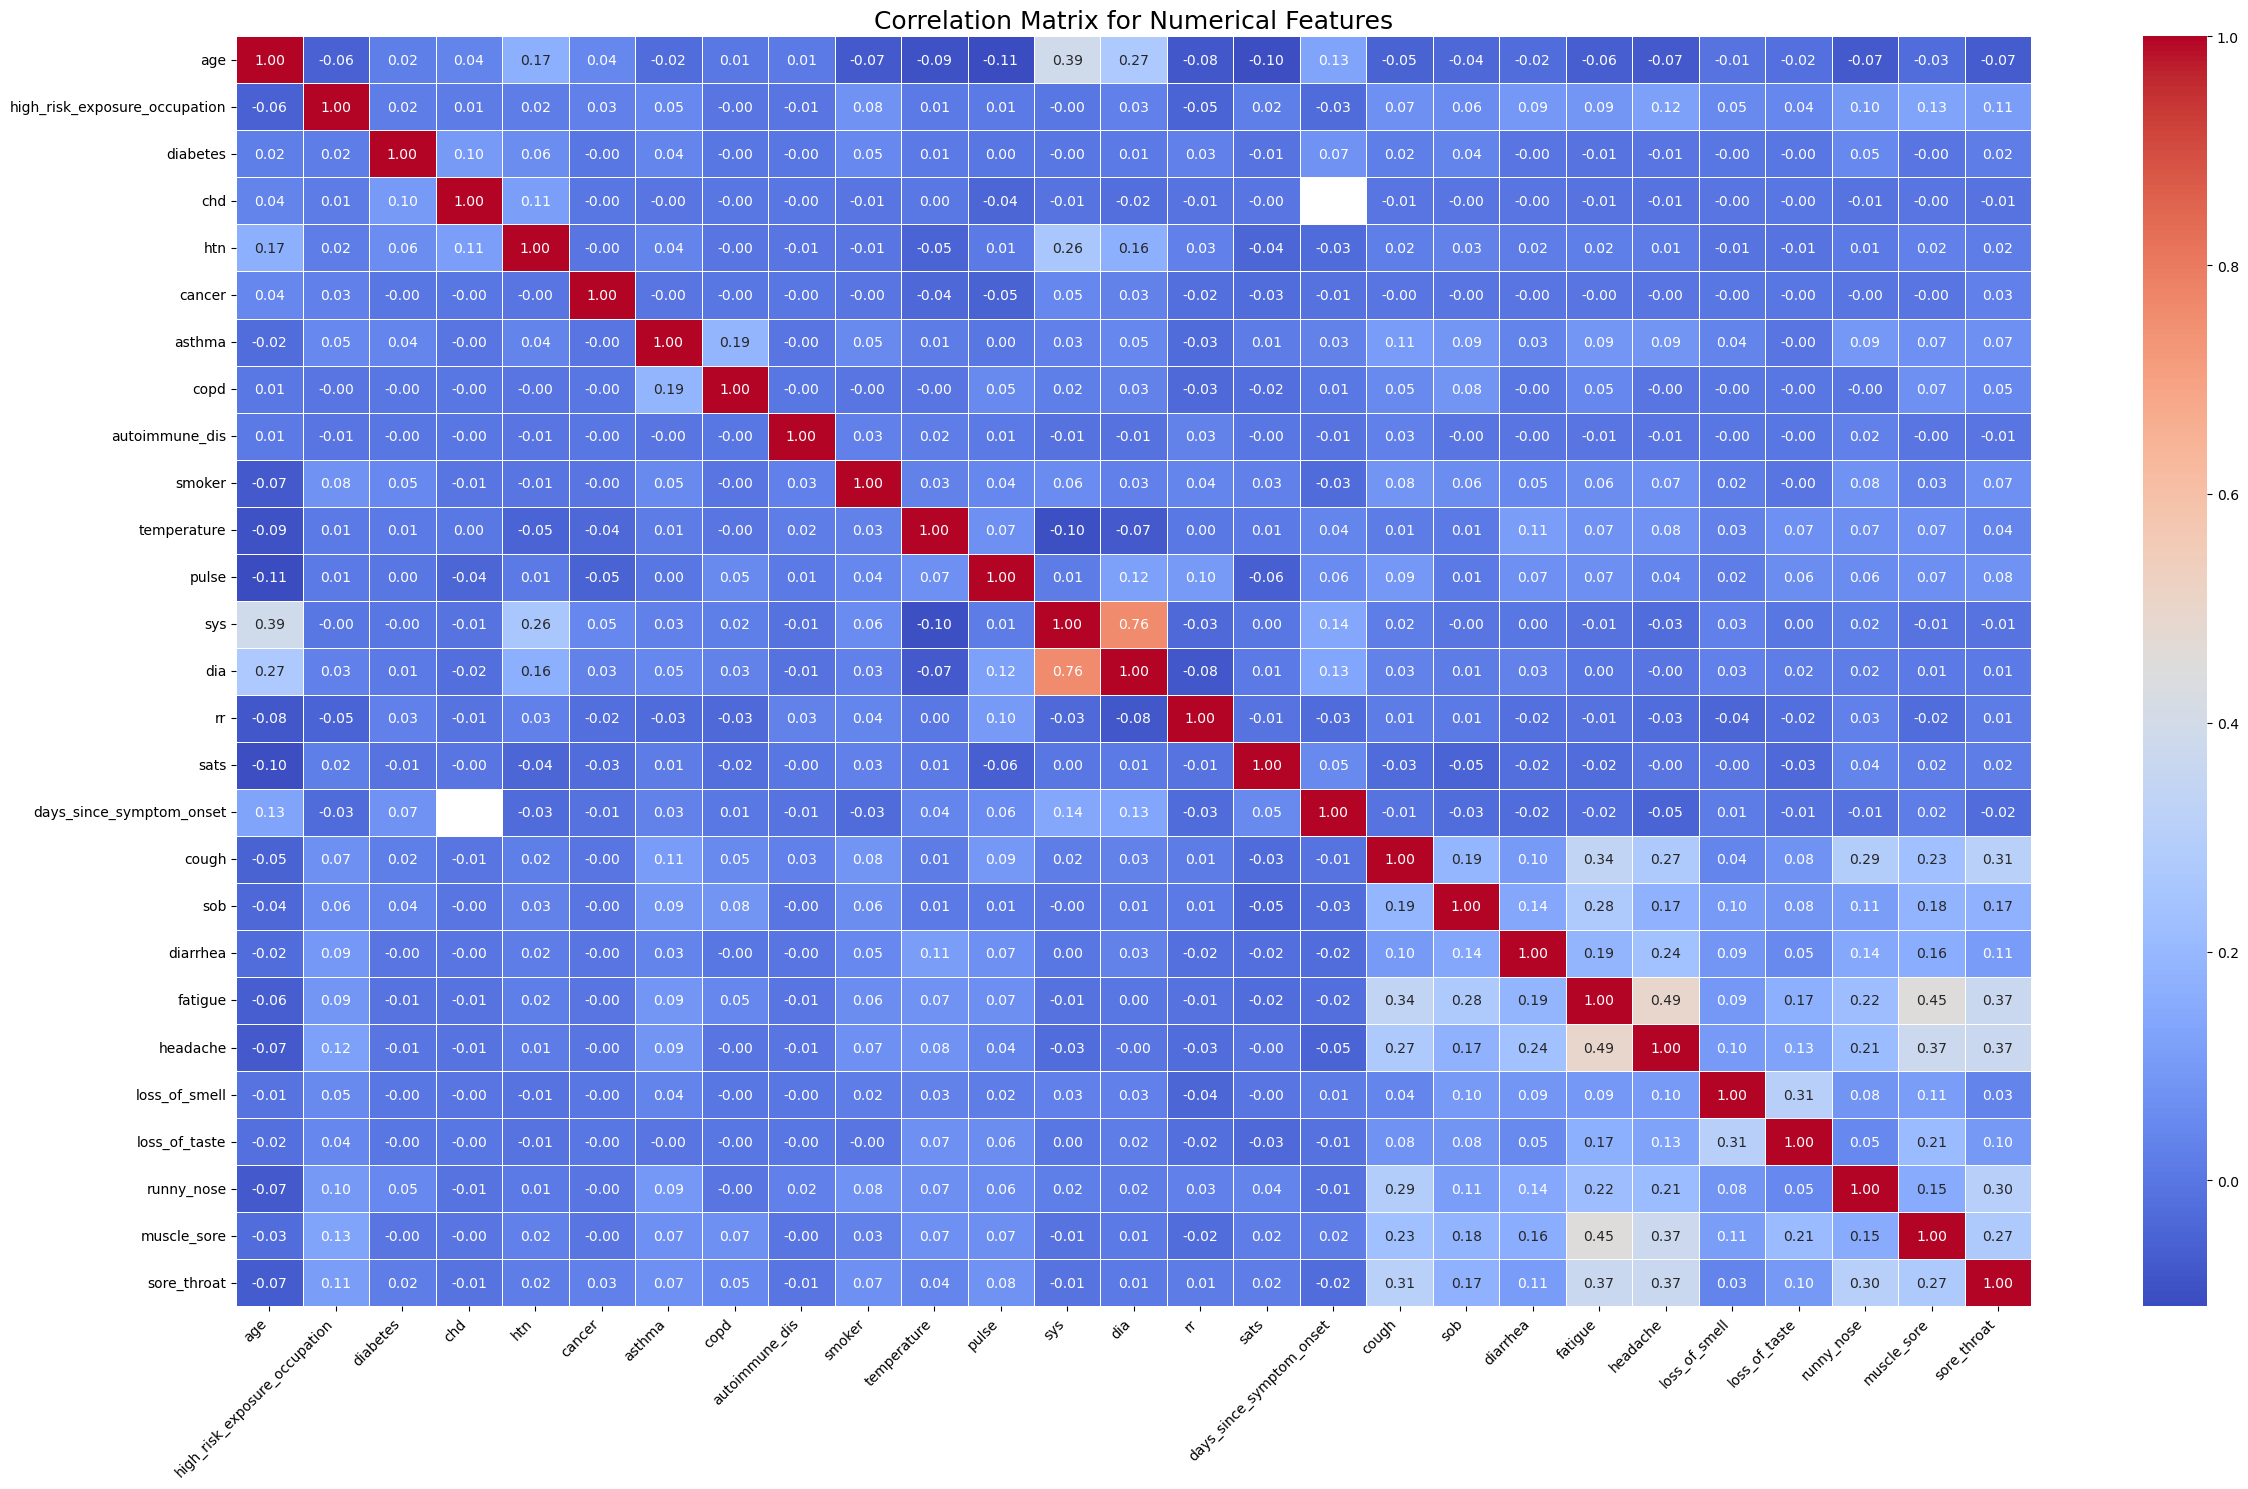

In [20]:
# Compute the correlation matrix
corr = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix for Numerical Features', fontsize=18)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [25]:
df['covid19_test_results'] = df['covid19_test_results'].map({
    'Negative': 0,
    'Positive': 1,
    'Other': 2  # Optional, if "Other" exists
})

df['covid19_test_results']


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
7289   NaN
7290   NaN
7291   NaN
7292   NaN
7293   NaN
Name: covid19_test_results, Length: 7294, dtype: float64

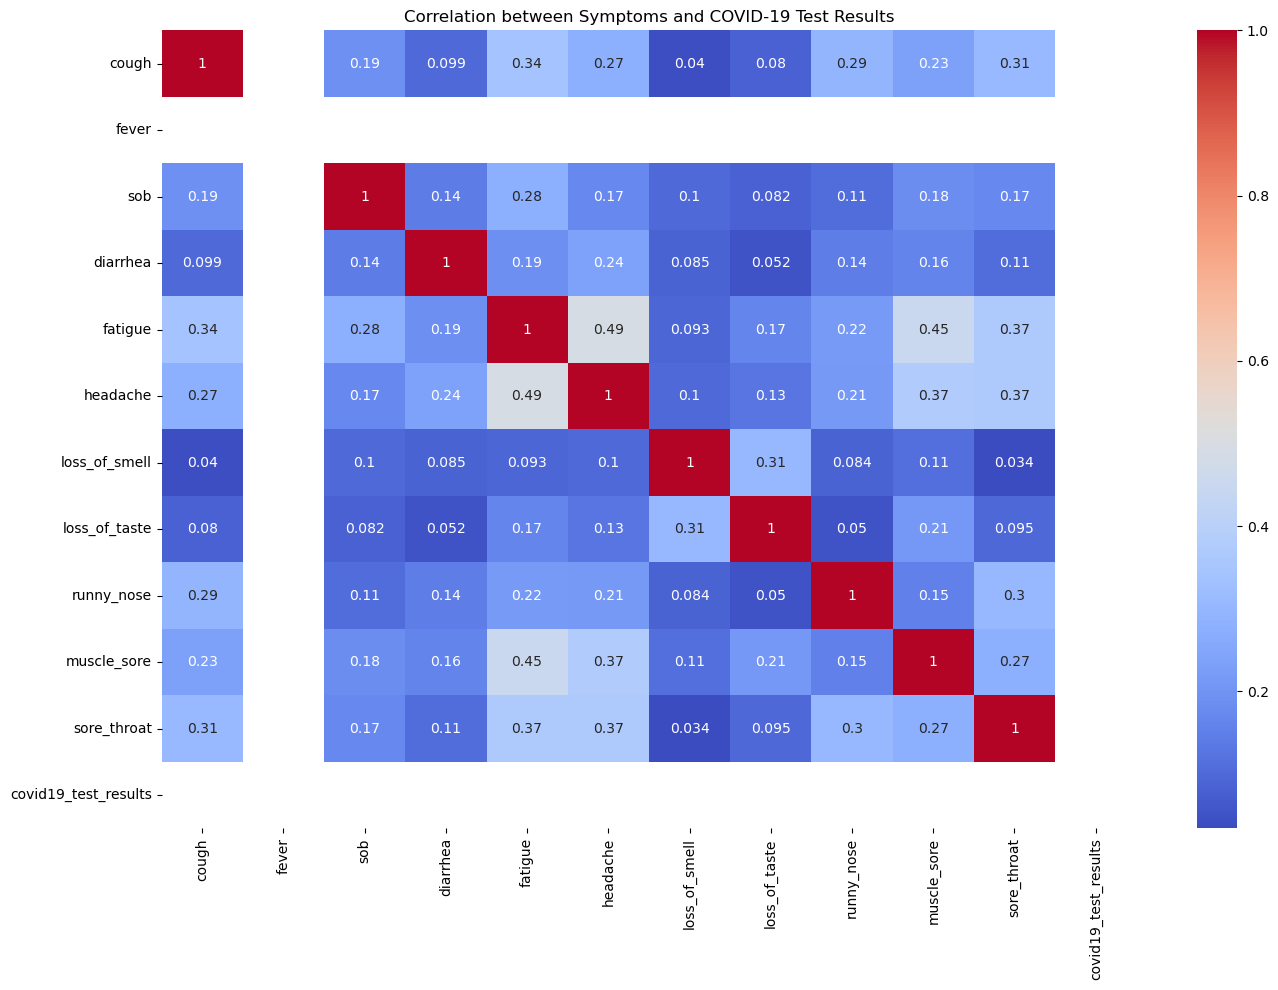

In [26]:
# Symptom columns
symptoms = [
    'cough', 'fever', 'sob', 'diarrhea', 'fatigue', 'headache',
    'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat'
]

# Convert object or boolean symptom values to 0/1
for col in symptoms:
    if df[col].dtype == 'object':
        df[col] = df[col].map({
            'True': 1,
            'False': 0,
            'true': 1,
            'false': 0
        })
    elif df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# Check which columns actually exist
symptom_cols = [col for col in symptoms if col in df.columns]

# Plot the heatmap
plt.figure(figsize=(14, 10))
correlation = df[symptom_cols + ['covid19_test_results']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Symptoms and COVID-19 Test Results')
plt.tight_layout()
plt.show()


In [27]:
# Complete symptom column list
symptoms = [
    'cough', 'fever', 'sob', 'diarrhea', 'fatigue', 'headache',
    'loss_of_smell', 'loss_of_taste', 'runny_nose', 'muscle_sore', 'sore_throat'
]

# Convert symptom columns to numeric 0/1 if needed
for col in symptoms:
    if df[col].dtype == 'object':
        df[col] = df[col].map({
            'True': 1,
            'False': 0,
            'true': 1,
            'false': 0
        })
    elif df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# Check the data types of the columns
print(df.dtypes)



batch_date                        object
test_name                         object
swab_type                         object
covid19_test_results             float64
age                                int64
high_risk_exposure_occupation       bool
high_risk_interactions            object
diabetes                            bool
chd                                 bool
htn                                 bool
cancer                              bool
asthma                              bool
copd                                bool
autoimmune_dis                      bool
smoker                              bool
temperature                      float64
pulse                            float64
sys                              float64
dia                              float64
rr                               float64
sats                             float64
rapid_flu_results                 object
rapid_strep_results               object
ctab                              object
labored_respirat

In [28]:
# Encode the target variable (COVID-19 test result)
print("\nEncoding target variable...")
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply encoding to the target variable
df['covid19_test_results_encoded'] = le.fit_transform(df['covid19_test_results'])

# Print class mapping for reference
print("Encoded values:", dict(zip(le.classes_, le.transform(le.classes_))))



Encoding target variable...
Encoded values: {nan: 0}


In [29]:
print("\nSelecting relevant features...")

# Medical condition columns
medical_cols = [
    'diabetes',
    'chd',
    'htn',
    'cancer',
    'asthma',
    'copd',
    'autoimmune_dis'
]

# Symptom columns
symptom_cols = [
    'cough',
    'fever',
    'sob',
    'diarrhea',
    'fatigue',
    'headache',
    'loss_of_smell',
    'loss_of_taste',
    'runny_nose',
    'muscle_sore',
    'sore_throat'
]

# Demographic and risk factor columns
demo_cols = [
    'age',
    'high_risk_exposure_occupation'
]

# Vital signs (some missing, but useful)
vital_cols = [
    'temperature',
    'pulse',
    'sys',
    'dia',
    'rr',
    'sats'
]

# Combine all selected features
selected_features = medical_cols + symptom_cols + demo_cols + vital_cols



Selecting relevant features...


In [30]:
# Prepare features and target
print("\nPreparing features and target...")
X = df[selected_features].copy()
y = df['covid19_test_results_encoded']

# Check for any remaining NaN values
nan_count = X.isna().sum().sum()
print(f"Remaining NaN values: {nan_count}")

# If there are still NaN values, fill them
if nan_count > 0:
    X = X.fillna(X.median())

    


Preparing features and target...
Remaining NaN values: 40456


In [31]:
from sklearn.model_selection import train_test_split

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
    # Optional stratify for balanced split
)

# Check data types of features in the training set
print(X_train.dtypes)


diabetes                            bool
chd                                 bool
htn                                 bool
cancer                              bool
asthma                              bool
copd                                bool
autoimmune_dis                      bool
cough                              int32
fever                            float64
sob                                int32
diarrhea                           int32
fatigue                            int32
headache                           int32
loss_of_smell                      int32
loss_of_taste                      int32
runny_nose                         int32
muscle_sore                        int32
sore_throat                        int32
age                                int64
high_risk_exposure_occupation       bool
temperature                      float64
pulse                            float64
sys                              float64
dia                              float64
rr              

In [32]:
print("Class distribution in y_train:")
print(y_train.value_counts())


Class distribution in y_train:
0    5835
Name: covid19_test_results_encoded, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris  # Example dataset
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load dataset (use your own dataset here)
data = load_iris()
X = data.data  # Features
y = data.target  # Target labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in the features
imputer = SimpleImputer(strategy='mean')  # You can choose 'median' or 'most_frequent' if appropriate
X_train_imputed = imputer.fit_transform(X_train)

# Handle class imbalance using SMOTE
print("\nHandling class imbalance with SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Print resampled data shape and target distribution
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution: {pd.Series(y_train_resampled).value_counts()}")



Handling class imbalance with SMOTE...
Resampled training set shape: (123, 4)
Resampled training set target distribution: 0    41
1    41
2    41
dtype: int64


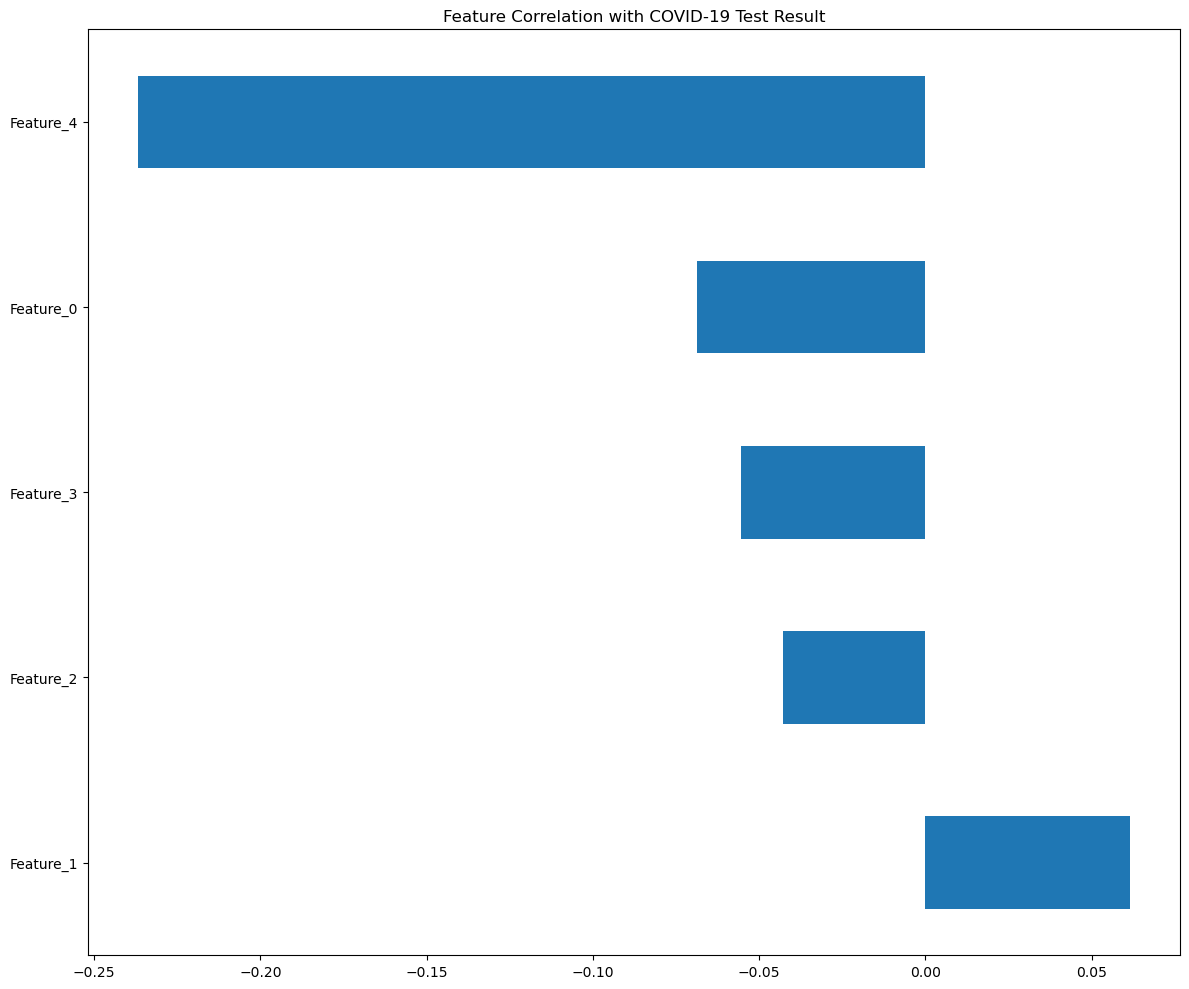

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'X' is a NumPy array and 'y' is a pandas Series representing the target
X = np.random.rand(100, 5)  # Example: 100 samples, 5 features (replace with your data)
y = np.random.randint(0, 2, 100)  # Example target variable (binary classification)

# Convert 'X' to a pandas DataFrame (you can provide column names if desired)
X_df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(X.shape[1])])

# Calculate correlation of each feature in X with y
correlations = X_df.corrwith(pd.Series(y)).sort_values(ascending=False)

# Plot the correlations
plt.figure(figsize=(12, 10))
correlations.plot(kind='barh')
plt.title('Feature Correlation with COVID-19 Test Result')
plt.tight_layout()

# Show the plot
plt.show()
